In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf

In [5]:
pip install tensorflow_hub


  Obtaining dependency information for tensorflow_hub from https://files.pythonhosted.org/packages/e5/50/00dba77925bf2a0a1e45d7bcf8a69a1d2534fb4bb277d9010bd148d2235e/tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tf-keras>=2.14.1 from https://files.pythonhosted.org/packages/19/26/ca8a6cca61f2a44f1e7ee71ebdb9c8dfbc4371f418db811cdca4641f6daa/tf_keras-2.15.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.7 MB 1.7 MB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.7 MB 2.5 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.7 MB 2.6 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.7 MB 2.8 MB/s eta 0:00:01
   -------------- ------------------------- 0.6/1.7 MB 2.8 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 2.9 MB/s eta 0:00:01
   ---------------------- ----------------- 1.0

In [8]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [9]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [10]:
#Download the classifier

CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

61306/61306 [==============================] - 0s 1us/step


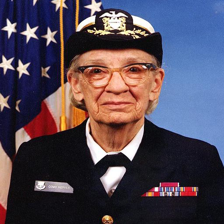

In [11]:
#Run it on a single image

import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [12]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [13]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 866ms/step


(1, 1001)

In [14]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

10484/10484 [==============================] - 0s 0us/step


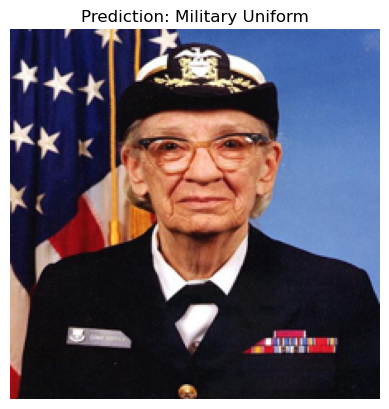

In [15]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:
#Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset
#We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [ ]:
#The images in the Dogs vs. Cats dataset are not all the same size.

for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

In [ ]:
#So we need to reformat all images to the resolution expected by MobileNet (224, 224).

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
#Run the classifier on a batch of images

image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

In [18]:
#Part 3: Do simple transfer learning with TensorFlow Hub

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [ ]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

In [ ]:
#Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

feature_extractor.trainable = False

In [ ]:
#Now wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.

model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

In [ ]:
#Train the model

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

In [ ]:
#Let's plot the training and validation accuracy/loss graphs.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Check the predictions

class_names = np.array(info.features['label'].names)
class_names

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")